In [2]:

import datetime
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime
import numpy as np
import requests
from functools import reduce
import warnings
warnings.filterwarnings('ignore')

In [3]:
df1=pd.read_csv("bond_yield.csv")
df2=pd.read_csv("canadian_economic_data.csv")
df3=pd.read_csv("V39050.csv", skiprows=11)
df4=pd.read_csv("V39078.csv", skiprows=11)
df5=pd.read_csv("V39079.csv", skiprows=11)

df1.columns = df1.columns.str.lower()
df2.columns = df2.columns.str.lower()
df3.columns = df3.columns.str.lower()
df4.columns = df4.columns.str.lower()
df5.columns = df5.columns.str.lower()

df1.rename(columns={'1-year govt bond yield': 'bond_yield_1_yr', '5-year govt bond yield': 'bond_yield_5_yr', '10-year govt bond yield': 'bond_yield_10_yr'},inplace=True)
df2.rename(columns={'us federal funds rate': 'us_funds_rate', 'cpi inflation yoy (%)': 'cpi_yoy', 'industrial production yoy (%)': 'production_yoy'},inplace=True)

 

In [4]:
def date_to_month(df3,field):

    # Step 1: Drop rows where field is not numeric
    df3 = df3[pd.to_numeric(df3[field], errors='coerce').notna()]
    
    # Convert 'date' to datetime
    df3['date'] = pd.to_datetime(df3['date'])
    
    # Step 2: Create a list of all months from the earliest to the latest date
    start_date = df3['date'].min()
    end_date = df3['date'].max()
    all_months = pd.date_range(start=start_date.replace(day=1), end=end_date, freq='MS')
    
    # Initialize an empty list to store the monthly data
    monthly_data = []
    
    # Sort the dataframe by date to ensure we can find the last date before the 1st
    df3 = df3.sort_values('date')
    
    # Step 3: Process each month
    for month_start in all_months:
        # Check if the 1st of the month exists in the data
        if month_start in df3['date'].values:
            # Use the value from the 1st of the month
            value = df3[df3['date'] == month_start][field].iloc[0] 
        else:
            # Find the last date before the 1st of the month
            before_first = df3[df3['date'] < month_start]
            if not before_first.empty:
                # Use the last available date before the 1st
                value = before_first.iloc[-1][field]
            else:
                # If no data exists before the 1st, skip this month
                continue
        
        # Append the result with the date as the 1st of the month
        monthly_data.append({'date': month_start, field: float(value)})
    
    # Create the final dataframe
    df_monthly = pd.DataFrame(monthly_data)
    
    # Step 4: Sort by date
    df_monthly = df_monthly.sort_values('date')
    
    return df_monthly

In [5]:
df3_1=date_to_month(df3,"v39050")
df4_1=date_to_month(df4,"v39078")
df5_1=date_to_month(df5,"v39079")
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])

In [6]:
df_combined = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), 
                     [df.rename(columns=str.lower) for df in [df1, df2, df3_1, df4_1, df5_1]])

In [7]:
df_combined.to_csv("df_combined.csv")
df_combined

,date,bond_yield_1_yr,bond_yield_5_yr,bond_yield_10_yr,us_funds_rate,cpi_yoy,production_yoy,v39050,v39078,v39079
0,2017-06-01,0.68,0.58,1.61,1.04,1.006945,7.074822,0.4987,0.75,0.50
1,2017-07-01,0.74,0.74,1.96,1.15,1.163647,4.475888,0.4970,0.75,0.50
2,2017-08-01,0.74,0.70,1.84,1.16,1.398626,2.618871,0.7475,1.00,0.75
3,2017-09-01,1.01,0.83,2.13,1.15,1.552801,1.699856,0.7588,1.00,0.75
4,2017-10-01,0.90,0.76,2.04,1.15,1.394292,1.557148,0.9693,1.25,1.00
...,...,...,...,...,...,...,...,...,...,...
90,2024-12-01,3.14,1.54,3.29,4.48,1.831979,-0.105260,3.7512,4.00,3.75
91,2025-01-01,2.96,1.45,3.18,4.33,1.895142,0.143734,3.2987,3.50,3.25
92,2025-02-01,2.84,1.33,2.98,4.33,2.644828,0.000000,3.0080,3.25,3.00
93,2025-03-01,2.65,1.49,3.12,4.33,2.315346,0.000000,2.9900,3.25,3.00


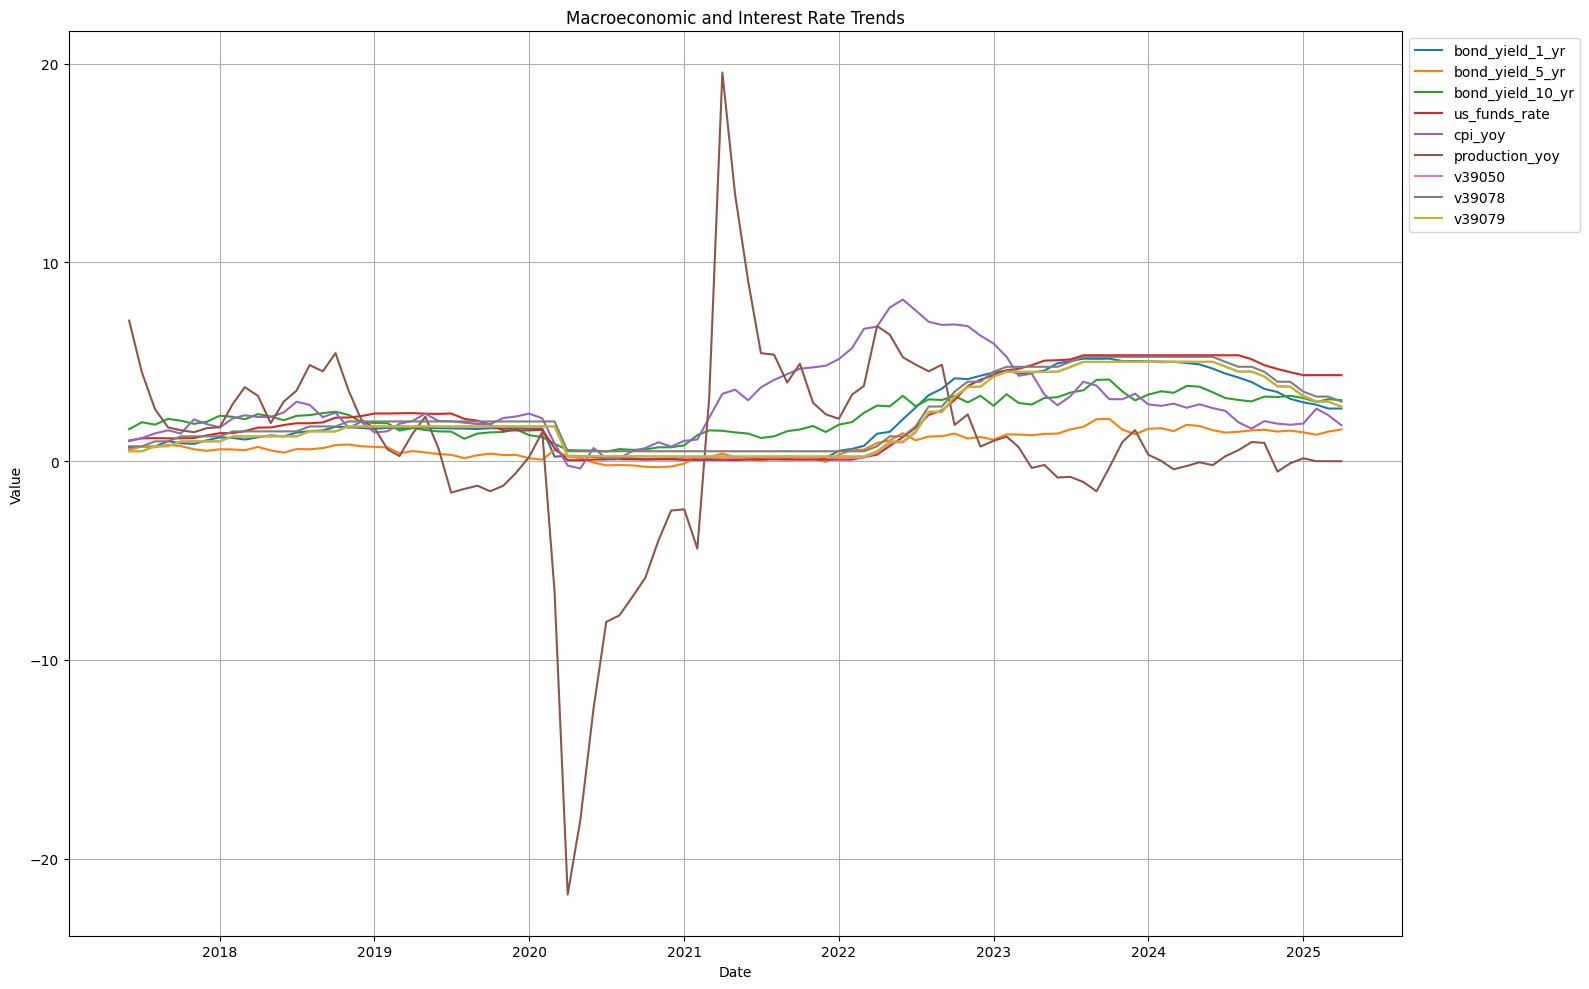

In [8]:


# Set 'date' as index for easier plotting (optional)
df_combined.set_index('date', inplace=True)

plt.figure(figsize=(16, 10))
for col in df_combined.columns:
    plt.plot(df_combined.index, df_combined[col], label=col)

plt.title('Macroeconomic and Interest Rate Trends')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()